<a href="https://colab.research.google.com/github/create-alt/diff_eq/blob/main/%E5%BE%AE%E5%88%86%E6%96%B9%E7%A8%8B%E5%BC%8F%E3%81%AE%E6%95%B0%E5%80%A4%E8%A8%88%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 微分方程式の数値計算

このノートブックでは、微分方程式を数値的に解く方法について実装しながら解説していきます。

※ 本ノートブックは Google Gemini及び OpenAI Chat GPTを活用して作成しております。

## イントロダクション

### 微分方程式とは
微分方程式は簡潔に表現すると、 **世界を傾きであらわす数式** です。

高校まででの一般的な方程式は、例えば平面上でxを与えられた時のただ1点のyの値を表す、いわゆる世界に道を描く数式でした。

これをより抽象的に表現したのが微分方程式です。

例えば平面であればこれを坂道にします。坂道が生まれると、初期地点次第でたどる経路が変わる、つまり、その平面の中に道の可能性が無数に生まれることになります。

下の図を見てもらうとわかりやすいです(矢印の方向が坂道の向きで、赤い点が初期地点、青の線がたどる経路)。

<img src="https://drive.google.com/uc?id=1RO1FqphU9tWub3Ru1_5IriIOyOnA1OS7" width="400">

このように、初期値を決めた時(≒微分方程式に値を逐次代入していく時)、その時々の経路を出力する(≒関数を定める≒特殊解を求める)ことができるのが微分方程式の特徴の一つだといえます。

(ここまですべて数学初学者の戯言です。怒らないでください。指摘はたくさんしてください。)

### 実装内容について
本ノートブックでは以下の内容を実装しています。

- 4次のルンゲクッタ法(後述)による数値シミュレーション

これを通して微分方程式を数値的に解く方法を身に着けていきたいと思います。

## 微分方程式の数値計算

本セクションでは、4次のルンゲクッタ法の実装を行っていきます。

### ライブラリの読み込み

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.preprocessing import MinMaxScaler

# グラフのスタイル設定（見やすくするため）
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("ライブラリの読み込みが完了しました。")

ライブラリの読み込みが完了しました。


### 微分方程式の定義

今回は下記ばねの減衰振動の方程式を用います。

これは解析解(数値計算でなく、方程式の文字のまま解いた結果)を求めることができるので4次のルンゲクッタ法の精度確認にも使用します。



運動方程式：
$$ \frac{d^2x}{dt^2} + 2\zeta\omega_n \frac{dx}{dt} + \omega_n^2 x = 0 $$

解析解：
$$
x(t) = e^{-\zeta\omega_n t} \left( x_0 \cos(\omega_d t) + \frac{v_0 + \zeta\omega_n x_0}{\omega_d} \sin(\omega_d t) \right)
\\
\text{where } \omega_d = \omega_n \sqrt{1 - \zeta^2}
$$

In [2]:
# --- パラメータ設定 ---
OMEGA_N = 2.0  # 固有角振動数
ZETA = 0.1     # 減衰比 (0 < zeta < 1 で不足減衰)

# --- ばねの減衰振動の微分方程式の定義 (数値計算用) ---
def spring_damper_deriv(t,state):
    x, v = state
    dxdt = v
    dvdt = -2 * ZETA * OMEGA_N * v - (OMEGA_N ** 2) * x
    return np.array([dxdt, dvdt])

# --- 解析解の定義 (理論的な正解) ---
def analytical_solution(t, x0, v0, wn=OMEGA_N, zeta=ZETA):
    # 減衰固有角振動数
    wd = wn * np.sqrt(1 - zeta**2)
    # 指数減衰項
    decay = np.exp(-zeta * wn * t)
    # 振動項 (初期条件から係数を導出)
    # x(0) = x0, v(0) = v0 を満たすようにA, Bを決定
    A = x0
    B = (v0 + zeta * wn * x0) / wd

    return decay * (A * np.cos(wd * t) + B * np.sin(wd * t))

## 下記のローレンツ方程式については今回は未使用(後々気が向いたら実装します、、、)
# """
# ここからローレンツ方程式の定義
# """
# # --- パラメータ設定 (カオス発生条件) ---
# PARAMS = {
#     'sigma': 10.0,
#     'rho': 28.0,
#     'beta': 8.0 / 3.0
# }

# # --- 微分方程式の定義 ---
# def lorenz_deriv(state, t, p):
#     x, y, z = state
#     dxdt = p['sigma'] * (y - x)
#     dydt = x * (p['rho'] - z) - y
#     dzdt = x * y - p['beta'] * z
#     return np.array([dxdt, dydt, dzdt])

### 4次のルンゲ・クッタ法の実装


4次のルンゲ・クッタ法は次の式で表されます。ここで、$y_{0}$が対象の微分方程式の初期値で、そこからn回計算していった時の値が$y_{n}$です。
$$
\begin{align}
\text{計算対象の微分方程式:} \quad & \frac{dy}{dt} = f(t, y) \\
\text{更新式:} \quad & y_{n+1} = y_n + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4) \\
\text{各kの定義:} \quad & k_1 = f(t_n, y_n) \\
& k_2 = f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_1\right) \\
& k_3 = f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_2\right) \\
& k_4 = f(t_n + h, y_n + h k_3)
\end{align}
$$

これだけを見てもよくわからないと思うので、以下の図をご覧ください(先ほど定義した方程式とは関係のないものですのでご注意ください)。

<img src="https://drive.google.com/uc?id=1_DzlAkd7WscS5LUbcRRehbH6on4zUkGs" width="400">

この図で示されているように、各kはその地点での勾配(坂の傾斜の向き)を表しています。

初め、$(t_n, y_n)$(いわゆるこの時点での初期値)での勾配k1を微分方程式に基づいて計算します。<br>(初めの微分方程式の説明を思い出していただくとわかりすいと思います。平面全体が坂としてあらわされていてその一点での傾きを計算するという話です。)

ひとつ前のコードセルで定義した微分方程式の数値計算用関数に代入するだけです。

続いて、目標地点(現在地からh先)の半分の地点までk1の勾配に沿って進んだ時のそこでの勾配k2を求めます。

そしてk2を用いて同様にk3を求め、k3を用いて目標地点での勾配k4を求めます。

最後にこれらの加重平均をとることで最終的に使用する勾配の値を計算し、$y_{n+1}$を求めます。

ちなみに、**4次の**ルンゲ・クッタ法と記載してきましたが、これは求めたい微分方程式の解をテイラー展開したときにその4次の項までの精度があるということです。

加重平均をとるときの各kごとの係数もこれを満たすよう決められています。

In [3]:
def rk4(func, t_span, y0, h):
    """
    4次のルンゲ・クッタ法 (Classic Runge-Kutta Method)

    Parameters
    ----------
    func : callable
        導関数 f(t, y)。引数は (t, y) の順序を想定。
        返り値は y と同じ形状の numpy array。
    t_span : tuple
        (開始時刻, 終了時刻) のタプル。例: (0, 10)
    y0 : array_like
        初期状態ベクトル。例: [1.0, 0.0]
    h : float
        時間の刻み幅 (step size)。例: 0.01

    Returns
    -------
    t_values : numpy.ndarray
        計算された時刻の配列
    y_values : numpy.ndarray
        計算された状態の配列 (ステップ数, 状態変数数)
    """
    # 時間軸の作成
    t_start, t_end = t_span
    t_values = np.arange(t_start, t_end, h)

    # 結果格納用の配列初期化
    # y0をnumpy配列化しておく（ベクトル計算対応のため）
    y0 = np.array(y0, dtype=float)
    n_steps = len(t_values)

    # y_valuesの形状: [時間ステップ数, 変数の数]
    # 例: 変数がx, vなら (N, 2)
    if y0.ndim == 0:
        y_values = np.zeros(n_steps) # スカラーの場合
    else:
        y_values = np.zeros((n_steps, *y0.shape)) # ベクトルの場合

    # 初期値のセット
    y_values[0] = y0
    current_y = y0

    # ループ計算
    for i in range(1, n_steps):
        t = t_values[i-1]

        # RK4の4ステップ
        k1 = func(t, current_y)
        k2 = func(t + h/2, current_y + h/2 * k1)
        k3 = func(t + h/2, current_y + h/2 * k2)
        k4 = func(t + h, current_y + h * k3)

        # 加重平均で更新
        current_y = current_y + (h / 6) * (k1 + 2*k2 + 2*k3 + k4)

        # 結果を保存
        y_values[i] = current_y

    return t_values, y_values

### ルンゲ・クッタ法による数値計算とその精度検証

先ほど実装したルンゲ・クッタ法を用いて実際にばねの減衰振動を解き、その結果を厳密解と比較して精度を検証します。

計算時間: 0.04396843910217285


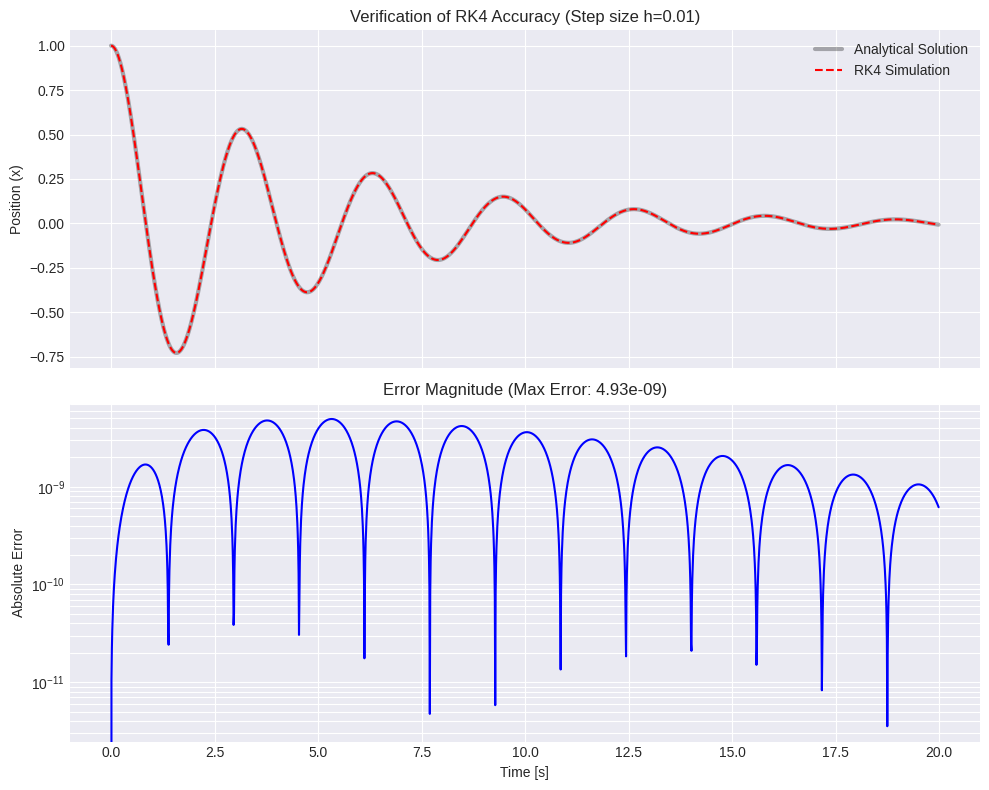

検証結果: 最大誤差は 4.93e-09 です。


In [4]:
# 条件設定
t_span = (0, 20)
y0 = [1.0, 0.0]  # 初期位置 1.0, 初期速度 0.0
h = 0.01         # 刻み幅

# A. 数値計算 (RK4)
start_time = time.time()
t_points, y_points = rk4(spring_damper_deriv, t_span, y0, h)
end_time = time.time()
print("計算時間:" , end_time - start_time)
x_numerical = y_points[:, 0] # 位置だけ取り出す

# B. 解析解 (Exact)
x_analy = analytical_solution(t_points, y0[0], y0[1], )

# C. 誤差 (Error)
error = np.abs(x_numerical - x_analy)
max_error = np.max(error)

# ----------------------------------------
# 4. 可視化
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# グラフ1: 軌道の比較
ax1.plot(t_points, x_analy, 'k-', lw=3, alpha=0.3, label='Analytical Solution')
ax1.plot(t_points, x_numerical, 'r--', lw=1.5, label='RK4 Simulation')
ax1.set_ylabel('Position (x)')
ax1.set_title(f'Verification of RK4 Accuracy (Step size h={h})')
ax1.legend()
ax1.grid(True)

# グラフ2: 誤差の推移
ax2.plot(t_points, error, color='blue')
ax2.set_ylabel('Absolute Error')
ax2.set_xlabel('Time [s]')
ax2.set_title(f'Error Magnitude (Max Error: {max_error:.2e})')
ax2.set_yscale('log') # 誤差は非常に小さいので対数軸が見やすい
ax2.grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()

print(f"検証結果: 最大誤差は {max_error:.2e} です。")

既存ライブラリのSciPy(サイパイ)を用いての結果と比較します。

計算時間: 0.013681650161743164


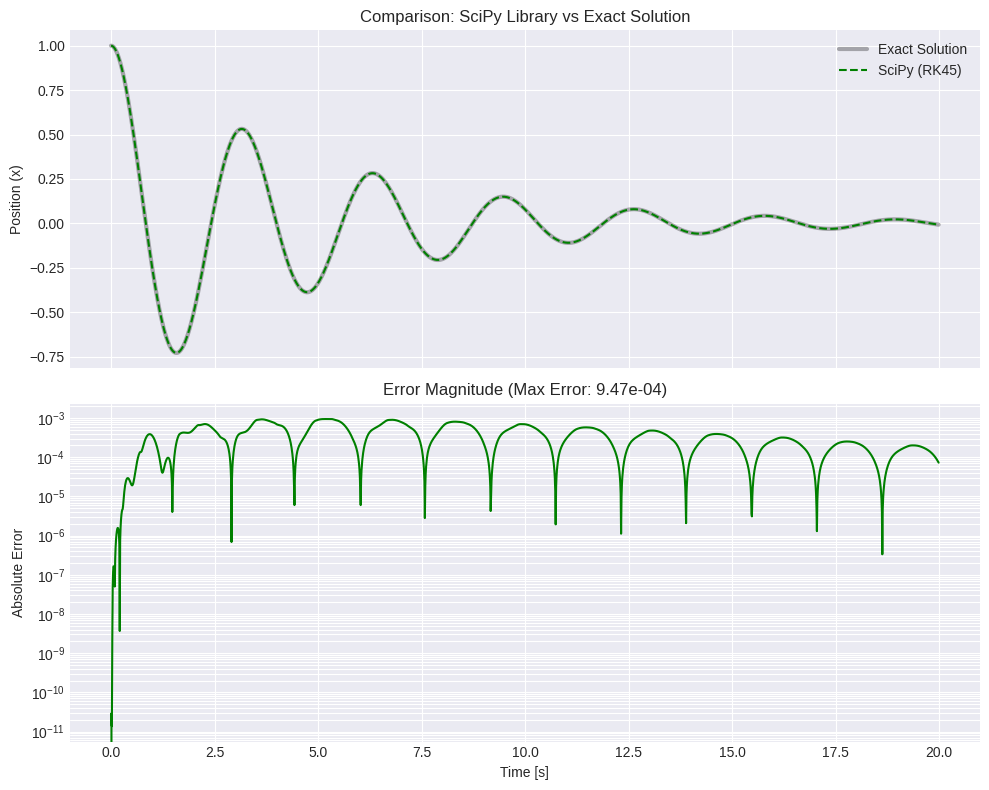

SciPy検証結果: 最大誤差は 9.47e-04 です。


In [5]:
from scipy.integrate import solve_ivp

# --- 計算条件の設定 ---
x0, v0 = 1.0, 0.0       # 初期値
t_start, t_end = 0, 20  # 開始・終了時刻
dt = 0.01               # 評価する時間刻み

# 比較のために時間軸を固定作成 (厳密解とSciPyで共通させる)
t_eval_points = np.arange(t_start, t_end, dt)

# ==========================================
# 1. SciPy による数値計算
# ==========================================
# solve_ivp(fun, t_span, y0, t_eval, method)
# fun は f(t, y) の形式である必要があるため、
# 既存の spring_damper_deriv(state, t) の引数を lambda で入れ替えます
start_time = time.time()
sol = solve_ivp(
    fun=lambda t, y: spring_damper_deriv(t, y),
    t_span=(t_start, t_end),
    y0=[x0, v0],
    t_eval=t_eval_points, # ここを指定すると、この時刻の解を返してくれます
    method='RK45'         # デフォルトの適応的ルンゲ・クッタ法 (5次精度)
)
end_time = time.time()
print("計算時間:" , end_time - start_time)

# SciPyの結果取得 (sol.y[0] が位置 x, sol.y[1] が速度 v)
x_scipy = sol.y[0]

# ==========================================
# 2. 厳密解 (Analytical Solution) の計算
# ==========================================
# 先ほど修正した通り、引数をすべて渡します
x_exact = analytical_solution(t_eval_points, x0, v0, OMEGA_N, ZETA)

# ==========================================
# 3. 誤差の計算と可視化
# ==========================================
error_scipy = np.abs(x_scipy - x_exact)
max_error_scipy = np.max(error_scipy)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 上段: 軌道の比較
ax1.plot(t_eval_points, x_exact, 'k-', lw=3, alpha=0.3, label='Exact Solution')
ax1.plot(t_eval_points, x_scipy, 'g--', lw=1.5, label='SciPy (RK45)')
ax1.set_ylabel('Position (x)')
ax1.set_title(f'Comparison: SciPy Library vs Exact Solution')
ax1.legend()
ax1.grid(True)

# 下段: 誤差
ax2.plot(t_eval_points, error_scipy, color='green')
ax2.set_ylabel('Absolute Error')
ax2.set_xlabel('Time [s]')
ax2.set_title(f'Error Magnitude (Max Error: {max_error_scipy:.2e})')
ax2.set_yscale('log') # 誤差が見やすいよう対数表示
ax2.grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()

print(f"SciPy検証結果: 最大誤差は {max_error_scipy:.2e} です。")

## おまけ

この資料を作っているときに、もともとしようと思っていたローレンツ方程式の数値解析と可視化をX上でMATLABが投稿していたので載せておきます。

いつか自分でも実装してみます。

https://x.com/matlab_japan/status/2001487584774537277?s=46